# Introduction

This notebook tackles [**Playground Series – Season 5, Episode 10: Predicting Road Accident Risk**](https://www.kaggle.com/competitions/playground-series-s5e10).

# Table of Contents

1. [Introduction](#Introduction)  
2. [Data Loading and Overview](#Data-Loading-and-Overview)
3. [Data Visualization](#Data-Visualization)
4. [Examine Original Dataset](#Examine-Original-Dataset)
5. [Dataset Comparison Report](#Dataset-Comparison-Report)
6. [Feature Engineering](#Feature-Engineering)
7. [Prepare Submission](#Prepare-Submission)


# Data Loading and Overview

In [1]:
%pip install --no-binary lightgbm --config-settings=cmake.define.USE_CUDA=ON lightgbm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip -q install -U optuna
%pip -q install optuna-integration[lightgbm]


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# --- Standard library
import os
import sys
import random
import warnings
from pathlib import Path
from contextlib import contextmanager
from time import time
from typing import Iterable

# --- Third-party
import numpy as np
import pandas as pd
import optuna
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_slice,
    plot_edf,
)
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from pandas.api.types import (
    is_categorical_dtype,
    is_numeric_dtype,
    is_object_dtype,
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score, RandomizedSearchCV
from sklearn import set_config
set_config(transform_output="pandas")
from statsmodels.graphics.gofplots import qqplot
from tqdm import tqdm
import lightgbm as lgbm
import xgboost as xgb

# --- Notebook settings
warnings.filterwarnings("ignore")

# Suppress XGBoost warnings about mismatched devices and tree methods.
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost.core')

%matplotlib inline

In [4]:
# Define some utilities functions
def configure_notebook(seed: int = 10301, float_precision: int = 3, max_columns: int = 15, max_rows: int = 25) -> int:
    """
    Configure notebook settings:
      - Disables warnings for cleaner output.
      - Sets pandas display options for better table formatting.
      - Returns a seed value for reproducibility.
    
    Parameters:
      seed (int): Random seed (default 548).
      float_precision (int): Number of decimal places for floats (default 3).
      max_columns (int): Maximum number of columns to display (default 15).
      max_rows (int): Maximum number of rows to display (default 25).

    Returns:
      int: The provided seed.
    """
    # Disable all warnings
    warnings.filterwarnings("ignore")
    
    # Set pandas display options for nicer output
    pd.options.display.float_format = f"{{:,.{float_precision}f}}".format
    pd.set_option("display.max_columns", max_columns)
    pd.set_option("display.max_rows", max_rows)

    # Set seeds for reproducibility in numpy and the standard random module
    np.random.seed(seed)
    random.seed(seed)
    
    return seed

def running_in_kaggle() -> bool:
    """
    Heuristics that are true in Kaggle notebooks:
    - Special directories exist (/kaggle/input, /kaggle/working)
    - Env var KAGGLE_KERNEL_RUN_TYPE is set
    - The kaggle_secrets module is available
    """
    try:
        if os.path.isdir("/kaggle/input") and os.path.isdir("/kaggle/working"):
            return True
        if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
            return True
        import kaggle_secrets  # noqa: F401  (only exists in Kaggle)
        return True
    except Exception:
        return False

# Use a context manager to suppress standard error output
# This is a robust way to handle warnings that bypass Python's warnings module
class SuppressStderr:
    def __enter__(self):
        self.original_stderr = sys.stderr
        sys.stderr = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stderr.close()
        sys.stderr = self.original_stderr

In [5]:
# Apply configuration and set random seeds for reproducibility
seed = configure_notebook()    

In [6]:
# Configurable flag to control whether GPU is used
USE_GPU = True

def resolve_lgbm_device(use_gpu: bool, X: pd.DataFrame, y: pd.Series,
                        platform_id: int = -1, device_id: int = -1):
    """
    Returns a dict of LightGBM params for the chosen device.
    Tries OpenCL GPU -> CPU.
    """
    if not use_gpu:
        return {"device_type": "cpu", "force_col_wise": True}  # CPU-only hint

    try:
        probe = lgbm.LGBMRegressor(
            n_estimators=10,
            device_type="gpu",
            max_bin=63,
            gpu_platform_id=platform_id, 
            gpu_device_id=device_id,
            verbosity=-1,
        )
        # tiny probe fit to validate the backend works
        _n = min(len(X), 2000)
        probe.fit(X.iloc[:_n], y.iloc[:_n])
        return {"device_type": "gpu", "gpu_platform_id": platform_id, "gpu_device_id": device_id}
    except Exception as e:
        print("OpenCL not available, falling back to CPU:", type(e).__name__, e)

    # Fall back to CPU
    return {"device_type": "cpu", "force_col_wise": True}

In [7]:
def eda_summary(df: pd.DataFrame) -> None:
    """
    Produce a concise, notebook-friendly Exploratory Data Analysis (EDA) summary.

    This utility prints and displays a standard set of diagnostics for a single
    DataFrame to help you quickly understand schema, completeness, and basic
    statistics. It is designed for use in Jupyter/IPython environments.

    The report includes:
      1. **First 5 rows** (transposed for vertical readability).
      2. **DataFrame info** (`df.info()`): dtypes and non-null counts.
      3. **Numeric describe** (`df.describe()`): count/mean/std/min/percentiles/max.
      4. **Categorical describe** (`df.select_dtypes(['object','category']).describe()`),
         or a note if none exist.
      5. **Missing values summary**: a table with per-column missing count and
         percentage of total rows.
      6. **Duplicate rows**: total number of duplicated records (`df.duplicated().sum()`).
      7. **Data types count**: frequency of each dtype in `df.dtypes`.
      8. **Correlation matrix** for numeric columns (if more than one numeric
         column exists), computed with Pearson correlation.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to summarize.

    Returns
    -------
    None
        Displays/prints the EDA sections and returns nothing.
    """
    # 1. Display the first few rows
    print("======== First 5 Rows ========")
    display(df.head().T)
    
    # 2. DataFrame information (data types, non-null counts, etc.)
    print("\n======== DataFrame Info ========")
    df.info()
    
    # 3. Descriptive statistics for numeric columns
    print("\n======== Descriptive Statistics (Numeric Columns) ========")
    display(df.describe().T)
    
    # 4. Descriptive statistics for categorical columns (if any)
    categorical_df = df.select_dtypes(include=['object', 'category'])
    print("\n======== Descriptive Statistics (Categorical Columns) ========")
    if not categorical_df.empty:
        display(categorical_df.describe())
    else:
        print("No categorical columns found.")
    
    # 5. Missing values summary
    print("\n======== Missing Values Summary ========")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_summary = pd.DataFrame({
        "Missing Count": missing,
        "Percentage": missing_percent
    })
    display(missing_summary)
    
    # 6. Count of duplicated rows
    print("\n======== Duplicated Rows ========")
    print(f"Total duplicated rows: {df.duplicated().sum()}")
    
    # 7. Count of each data type
    print("\n======== Data Types Count ========")
    display(df.dtypes.value_counts())
    
    # 8. Correlation matrix for numeric variables (if more than one exists)
    numeric_cols = df.select_dtypes(include=[np.number])
    if numeric_cols.shape[1] > 1:
        print("\n======== Correlation Matrix (Numeric Columns) ========")
        display(numeric_cols.corr())
    else:
        print("\n======== Correlation Matrix ========")
        print("Not enough numeric columns to compute correlation.")
    
    # 9. Value counts for categorical variables with low cardinality
    print("\n======== Value Counts for Categorical Columns (Low Cardinality) ========")
    if not categorical_df.empty:
        for col in categorical_df.columns:
            if df[col].nunique() <= 20:
                print(f"\nValue Counts for '{col}':")
                display(df[col].value_counts())
    else:
        print("No categorical columns found.")


#### Read the training data and display a bit of it

In [8]:
DATA_DIR = Path('/kaggle/input/playground-series-s5e10') if running_in_kaggle() else Path('data')

training_df = pd.read_csv(DATA_DIR / 'train.csv')
training_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.060,35,daylight,rainy,False,True,afternoon,False,True,1,0.130
1,1,urban,4,0.990,35,daylight,clear,True,False,evening,True,True,0,0.350
2,2,rural,4,0.630,70,dim,clear,False,True,morning,True,False,2,0.300
3,3,highway,4,0.070,35,dim,rainy,True,True,morning,False,False,1,0.210
4,4,rural,1,0.580,60,daylight,foggy,False,False,evening,True,False,1,0.560


#### Read the test data and display it

In [9]:
test_df = pd.read_csv(DATA_DIR / 'test.csv')
test_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.340,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.040,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.590,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.950,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.860,35,daylight,clear,True,False,evening,False,True,3


#### Get rid of the 'id' column before examining the data.  Also, it'll confuse training.

In [10]:
training_df.drop('id', axis=1, inplace=True)
training_df.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,urban,2,0.060,35,daylight,rainy,False,True,afternoon,False,True,1,0.130
1,urban,4,0.990,35,daylight,clear,True,False,evening,True,True,0,0.350
2,rural,4,0.630,70,dim,clear,False,True,morning,True,False,2,0.300
3,highway,4,0.070,35,dim,rainy,True,True,morning,False,False,1,0.210
4,rural,1,0.580,60,daylight,foggy,False,False,evening,True,False,1,0.560


In [11]:
# Save a copy with the ID for use later
test_ids = test_df['id'].copy()

test_df.drop('id', axis=1, inplace=True)
test_df.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,highway,2,0.340,45,night,clear,True,True,afternoon,True,True,1
1,urban,3,0.040,45,dim,foggy,True,False,afternoon,True,False,0
2,urban,2,0.590,35,dim,clear,True,False,afternoon,True,True,1
3,rural,4,0.950,35,daylight,rainy,False,False,afternoon,False,False,2
4,highway,2,0.860,35,daylight,clear,True,False,evening,False,True,3


## Exploratory Data Analysis

In [12]:
eda_summary(training_df)

======== First 5 Rows ========


,0,1,2,3,4
road_type,urban,urban,rural,highway,rural
num_lanes,2,4,4,4,1
curvature,0.060,0.990,0.630,0.070,0.580
speed_limit,35,35,70,35,60
lighting,daylight,daylight,dim,dim,daylight
weather,rainy,clear,clear,rainy,foggy
road_signs_present,False,True,False,True,False
public_road,True,False,True,True,False
time_of_day,afternoon,evening,morning,morning,evening
holiday,False,True,True,False,True



======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  object 
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  object 
 5   weather                 517754 non-null  object 
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  object 
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object

,count,mean,std,min,25%,50%,75%,max
num_lanes,"517,754.000",2.492,1.120,1.000,1.000,2.000,3.000,4.000
curvature,"517,754.000",0.489,0.273,0.000,0.260,0.510,0.710,1.000
speed_limit,"517,754.000",46.113,15.789,25.000,35.000,45.000,60.000,70.000
num_reported_accidents,"517,754.000",1.188,0.896,0.000,1.000,1.000,2.000,7.000
accident_risk,"517,754.000",0.352,0.166,0.000,0.230,0.340,0.460,1.000



======== Descriptive Statistics (Categorical Columns) ========


,road_type,lighting,weather,time_of_day
count,517754,517754,517754,517754
unique,3,3,3,3
top,highway,dim,foggy,morning
freq,173672,183826,181463,173410



======== Missing Values Summary ========


,Missing Count,Percentage
road_type,0,0.000
num_lanes,0,0.000
curvature,0,0.000
speed_limit,0,0.000
lighting,0,0.000
weather,0,0.000
road_signs_present,0,0.000
public_road,0,0.000
time_of_day,0,0.000
holiday,0,0.000



======== Duplicated Rows ========
Total duplicated rows: 656

======== Data Types Count ========


object     4
bool       4
int64      3
float64    2
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
num_lanes,1.000,-0.020,0.001,0.018,-0.006
curvature,-0.020,1.000,0.008,0.145,0.544
speed_limit,0.001,0.008,1.000,0.031,0.431
num_reported_accidents,0.018,0.145,0.031,1.000,0.214
accident_risk,-0.006,0.544,0.431,0.214,1.000



======== Value Counts for Categorical Columns (Low Cardinality) ========

Value Counts for 'road_type':


road_type
highway    173672
rural      172719
urban      171363
Name: count, dtype: int64


Value Counts for 'lighting':


lighting
dim         183826
daylight    178015
night       155913
Name: count, dtype: int64


Value Counts for 'weather':


weather
foggy    181463
clear    179306
rainy    156985
Name: count, dtype: int64


Value Counts for 'time_of_day':


time_of_day
morning      173410
evening      172837
afternoon    171507
Name: count, dtype: int64

#### Show the statistics and structure of the test data

In [13]:
eda_summary(test_df)

======== First 5 Rows ========


,0,1,2,3,4
road_type,highway,urban,urban,rural,highway
num_lanes,2,3,2,4,2
curvature,0.340,0.040,0.590,0.950,0.860
speed_limit,45,45,35,35,35
lighting,night,dim,dim,daylight,daylight
weather,clear,foggy,clear,rainy,clear
road_signs_present,True,True,True,False,True
public_road,True,False,False,False,False
time_of_day,afternoon,afternoon,afternoon,afternoon,evening
holiday,True,True,True,False,False



======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172585 entries, 0 to 172584
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               172585 non-null  object 
 1   num_lanes               172585 non-null  int64  
 2   curvature               172585 non-null  float64
 3   speed_limit             172585 non-null  int64  
 4   lighting                172585 non-null  object 
 5   weather                 172585 non-null  object 
 6   road_signs_present      172585 non-null  bool   
 7   public_road             172585 non-null  bool   
 8   time_of_day             172585 non-null  object 
 9   holiday                 172585 non-null  bool   
 10  school_season           172585 non-null  bool   
 11  num_reported_accidents  172585 non-null  int64  
dtypes: bool(4), float64(1), int64(3), object(4)
memory usage: 11.2+ MB

======== Descriptive Stati

,count,mean,std,min,25%,50%,75%,max
num_lanes,"172,585.000",2.494,1.119,1.000,1.000,2.000,3.000,4.000
curvature,"172,585.000",0.487,0.272,0.000,0.260,0.510,0.710,1.000
speed_limit,"172,585.000",46.103,15.787,25.000,35.000,45.000,60.000,70.000
num_reported_accidents,"172,585.000",1.186,0.897,0.000,1.000,1.000,2.000,7.000



======== Descriptive Statistics (Categorical Columns) ========


,road_type,lighting,weather,time_of_day
count,172585,172585,172585,172585
unique,3,3,3,3
top,highway,dim,foggy,morning
freq,58080,61143,60236,57747



======== Missing Values Summary ========


,Missing Count,Percentage
road_type,0,0.000
num_lanes,0,0.000
curvature,0,0.000
speed_limit,0,0.000
lighting,0,0.000
weather,0,0.000
road_signs_present,0,0.000
public_road,0,0.000
time_of_day,0,0.000
holiday,0,0.000



======== Duplicated Rows ========
Total duplicated rows: 1203

======== Data Types Count ========


object     4
bool       4
int64      3
float64    1
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


,num_lanes,curvature,speed_limit,num_reported_accidents
num_lanes,1.000,-0.021,0.002,0.017
curvature,-0.021,1.000,0.006,0.143
speed_limit,0.002,0.006,1.000,0.030
num_reported_accidents,0.017,0.143,0.030,1.000



======== Value Counts for Categorical Columns (Low Cardinality) ========

Value Counts for 'road_type':


road_type
highway    58080
rural      57409
urban      57096
Name: count, dtype: int64


Value Counts for 'lighting':


lighting
dim         61143
daylight    59397
night       52045
Name: count, dtype: int64


Value Counts for 'weather':


weather
foggy    60236
clear    59982
rainy    52367
Name: count, dtype: int64


Value Counts for 'time_of_day':


time_of_day
morning      57747
evening      57629
afternoon    57209
Name: count, dtype: int64

# Data Visualization

#### Target & Feature distributions — What & why
We first examine the distribution of **accident_risk** and the marginal distributions of key numeric features.
This reveals central tendency, spread, skewness, and potential multi‑modality (e.g., half/double‑time clusters).
These insights inform scaling and simple transforms and guard against outlier‑driven RMSE errors.

In [14]:
def split_columns(df: pd.DataFrame, max_cardinality: int = 30):
    """
    Heuristic split into numeric vs categorical, with a cardinality cap for cats.
    """
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in df.columns if c not in num_cols]
    
    # treat low-unique integer columns as categorical (IDs will be filtered later)
    for c in list(num_cols):
        if pd.api.types.is_integer_dtype(df[c]) and df[c].nunique(dropna=True) <= max_cardinality:
            cat_cols.append(c)
            num_cols.remove(c)
            
    # drop high-cardinality cats from categorical plotting by default
    low_card_cats = [c for c in cat_cols if df[c].nunique(dropna=True) <= max_cardinality]
    
    return num_cols, low_card_cats
    
# short axis label helper
def colname(v):
    return str(v).replace("_", " ").title()

In [15]:
def plot_missingness(df: pd.DataFrame):
    miss = df.isna().mean().sort_values(ascending=False)
    miss = miss[miss > 0]
    if miss.empty:
        print("No missing values.")
        return
        
    plt.figure(figsize=(8, max(2, 0.3 * len(miss))))
    plt.barh(miss.index, miss.values)
    plt.xlabel("Fraction Missing")
    plt.title("Missingness by Column")
    plt.gca().invert_yaxis()
    plt.show()
    
    display(miss.to_frame("missing_frac"))


In [16]:
def plot_numeric_univariate(df: pd.DataFrame, cols: Iterable[str], kde: bool = True):
    for c in cols:
        x = df[c].dropna().to_numpy()
        if x.size == 0:
            continue

        # ECDF (robust view of distribution)
        xs = np.sort(x)
        ys = np.arange(1, xs.size + 1) / xs.size
        plt.figure(figsize=(7, 4))
        plt.plot(xs, ys)
        plt.xlabel(colname(c)); plt.ylabel("ECDF")
        plt.title(f"{c} – Empirical CDF")
        plt.show()

        # Smooth density (KDE) if supported and enough data
        if kde and xs.size >= 50:
            try:
                from scipy.stats import gaussian_kde
                grid = np.linspace(xs.min(), xs.max(), 256)
                dens = gaussian_kde(xs)(grid)
                plt.figure(figsize=(7, 4))
                plt.plot(grid, dens)
                plt.xlabel(colname(c)); plt.ylabel("Density")
                plt.title(f"{c} – Density (KDE)")
                plt.show()
            except Exception as e:
                # skip quietly if scipy not available
                pass

In [17]:
def plot_categorical_univariate(df: pd.DataFrame, cols, top_n = 20, normalize = False):
    for c in cols:
        vc = df[c].astype("object").value_counts(dropna=False)
        if vc.empty:
            continue
            
        vc = vc.head(top_n)
        plt.figure(figsize=(8, max(2, 0.35 * len(vc))))
        plt.barh(vc.index.astype(str), vc.values if not normalize else (vc.values / vc.sum()))
        plt.gca().invert_yaxis()
        plt.xlabel("Count" if not normalize else "Proportion")
        plt.title(f"{c} – Top {len(vc)} Categories")
        plt.show()

In [18]:
def collapse_rare_categories(s: pd.Series, min_count: int = 50) -> pd.Series:
    vc = s.value_counts()
    keep = vc[vc >= min_count].index
    return s.where(s.isin(keep), other="__OTHER__")

In [19]:
TARGET = "accident_risk"
IS_CLASSIFICATION = training_df[TARGET].nunique() <= 10 and training_df[TARGET].dtype != float

In [20]:
def numeric_vs_target_regression(df, feature, target, n_bins=20):
    # guardrails
    s = df[feature]
    if pd.api.types.is_bool_dtype(s) or s.nunique(dropna=True) < 2:
        return  # treat bools as categorical elsewhere; skip constants

    d = df[[feature, target]].dropna()
    if d.empty:
        return

    # Use quantile bins unless the feature has very few unique values
    if d[feature].nunique() <= n_bins:
        # group by the actual values (e.g., speed_limit with few discrete values)
        gb = d.groupby(feature, sort=True)[target]
        centers = gb.mean().index.to_numpy(dtype=float)  # numeric categories
    else:
        q = pd.qcut(
            d[feature],
            q=min(n_bins, d[feature].nunique()),
            duplicates="drop"
        )
        gb = d.groupby(q, observed=True)[target]
        idx = gb.mean().index  # IntervalIndex
        # bin centers
        centers = getattr(idx, "mid", np.array([(iv.left + iv.right) / 2.0 for iv in idx]))

    means = gb.mean().to_numpy()
    stds  = gb.std(ddof=0).to_numpy()

    # mean line
    plt.figure(figsize=(7, 4))
    plt.plot(centers, means)
    plt.xlabel(colname(feature)); plt.ylabel(f"Mean {target}")
    plt.title(f"{feature} – Mean {target} by Bin")
    plt.show()

    # std line
    plt.figure(figsize=(7, 4))
    plt.plot(centers, stds)
    plt.xlabel(colname(feature)); plt.ylabel(f"Std({target})")
    plt.title(f"{feature} – Target Std by Bin")
    plt.show()


In [21]:
def categorical_vs_target_classification(df, feature, target, min_count = 50, top_n = 20):
    s = collapse_rare_categories(df[feature].astype("object"), min_count=min_count)
    d = pd.DataFrame({feature: s, target: df[target]}).dropna()
    grp = d.groupby(feature)
    counts = grp.size().sort_values(ascending=False).head(top_n)
    cats = counts.index

    rate = grp[target].mean().reindex(cats)

    # counts
    plt.figure(figsize=(8, max(2, 0.35*len(cats))))
    plt.barh([str(c) for c in cats], counts.values)
    plt.gca().invert_yaxis()
    plt.xlabel("Count"); plt.title(f"{feature} – Top {len(cats)} Counts")
    plt.show()

    # target rates
    plt.figure(figsize=(8, max(2, 0.35*len(cats))))
    plt.barh([str(c) for c in cats], rate.values)
    plt.gca().invert_yaxis()
    plt.xlabel(f"Mean {target}"); plt.title(f"{feature} – Target Rate (Top {len(cats)})")
    plt.show()

In [22]:
def numeric_vs_target_regression(df, feature, target, n_bins = 20):
    # guardrails
    s = df[feature]
    if pd.api.types.is_bool_dtype(s) or s.nunique(dropna = True) < 2:
        return  # treat bools as categorical elsewhere; skip constants

    d = df[[feature, target]].dropna()
    if d.empty:
        return

    # Use quantile bins unless the feature has very few unique values
    if d[feature].nunique() <= n_bins:
        # group by the actual values (e.g., speed_limit with few discrete values)
        gb = d.groupby(feature, sort=True)[target]
        centers = gb.mean().index.to_numpy(dtype=float)  # numeric categories
    else:
        q = pd.qcut(
            d[feature],
            q=min(n_bins, d[feature].nunique()),
            duplicates="drop"
        )
        gb = d.groupby(q, observed=True)[target]
        idx = gb.mean().index  # IntervalIndex
        # bin centers
        centers = getattr(idx, "mid", np.array([(iv.left + iv.right) / 2.0 for iv in idx]))

    means = gb.mean().to_numpy()
    stds  = gb.std(ddof=0).to_numpy()

    # mean line
    plt.figure(figsize=(7, 4))
    plt.plot(centers, means)
    plt.xlabel(colname(feature)); plt.ylabel(f"Mean {target}")
    plt.title(f"{feature} – Mean {target} by Bin")
    plt.show()

    # std line
    plt.figure(figsize=(7, 4))
    plt.plot(centers, stds)
    plt.xlabel(colname(feature)); plt.ylabel(f"Std({target})")
    plt.title(f"{feature} – Target Std by Bin")
    plt.show()

In [23]:
def categorical_vs_target_regression(df, feature, target, min_count=50, top_n=20):
    s = collapse_rare_categories(df[feature].astype("object"), min_count=min_count)
    d = pd.DataFrame({feature: s, target: df[target]}).dropna()
    stats = d.groupby(feature)[target].agg(["count","mean"]).sort_values("count", ascending=False).head(top_n)

    plt.figure(figsize=(8, max(2, 0.35*len(stats))))
    plt.barh(stats.index.astype(str), stats["mean"].values)
    plt.gca().invert_yaxis()
    plt.xlabel(f"Mean {target}")
    plt.title(f"{feature} – Mean {target} (Top {len(stats)})")
    plt.show()

    plt.figure(figsize=(8, max(2, 0.35*len(stats))))
    plt.barh(stats.index.astype(str), stats["count"].values)
    plt.gca().invert_yaxis()
    plt.xlabel("Count")
    plt.title(f"{feature} – Count (Top {len(stats)})")
    plt.show()

In [24]:
from scipy.stats import chi2_contingency

def cramers_v(x: pd.Series, y: pd.Series) -> float:
    tbl = pd.crosstab(x, y)
    chi2 = chi2_contingency(tbl, correction=False)[0]
    n = tbl.values.sum()
    r, k = tbl.shape
    v = np.sqrt(chi2 / (n * (min(r, k) - 1)))
    return float(v)

def categorical_associations(df: pd.DataFrame, cats):
    cats = [c for c in cats if df[c].notna().any()]
    out = pd.DataFrame(index=cats, columns=cats, dtype=float)
    for i, c1 in enumerate(cats):
        for c2 in cats[i:]:
            v = cramers_v(df[c1].astype("object"), df[c2].astype("object"))
            out.loc[c1, c2] = out.loc[c2, c1] = v
    return out

def numeric_correlations(df: pd.DataFrame, nums):
    return df[nums].corr(numeric_only=True)

In [25]:
def has_target(df, target):
    return target is not None and target in df.columns

def run_eda(df: pd.DataFrame, target: str, max_cat_card=30):
    df_wo_target = df.drop(columns=[target]) if has_target(df, target) else df
    num_cols, cat_cols = split_columns(df_wo_target, max_cardinality=max_cat_card)

    print(f"Numeric: {len(num_cols)} | Categorical (≤{max_cat_card} uniq): {len(cat_cols)}")

    plot_missingness(df)

    if num_cols:
        plot_numeric_univariate(df, num_cols, kde=True)

    if cat_cols:
        plot_categorical_univariate(df, cat_cols, top_n=20, normalize=False)

    if target and target in df.columns:
        if pd.api.types.is_numeric_dtype(df[target]) and df[target].nunique() > 20:
            # Regression-style
            for c in num_cols[:20]:
                numeric_vs_target_regression(df, c, target)
            for c in cat_cols[:20]:
                categorical_vs_target_regression(df, c, target)
        else:
            # Classification-style
            for c in num_cols[:20]:
                numeric_vs_target_classification(df, c, target)
            for c in cat_cols[:20]:
                categorical_vs_target_classification(df, c, target)

## Training Dataset EDA

Numeric: 1 | Categorical (≤30 uniq): 11
No missing values.


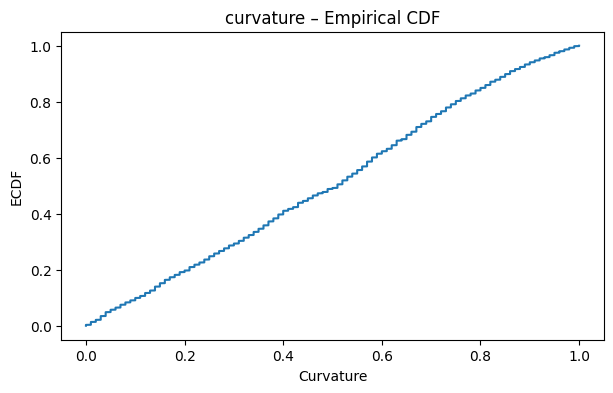

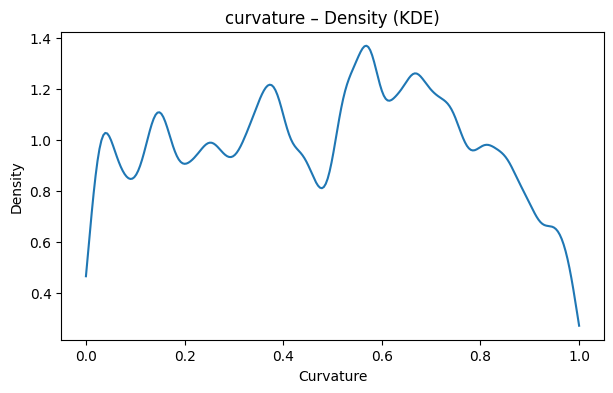

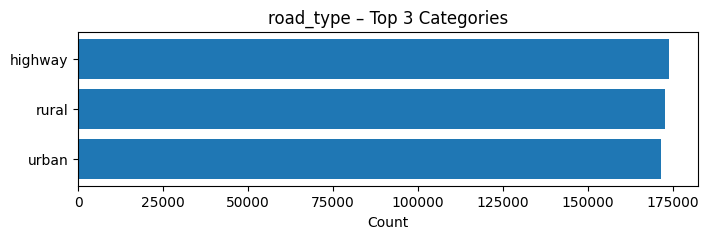

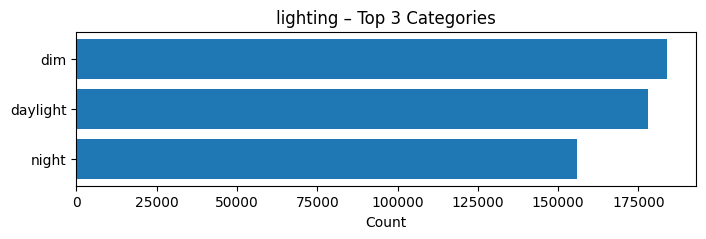

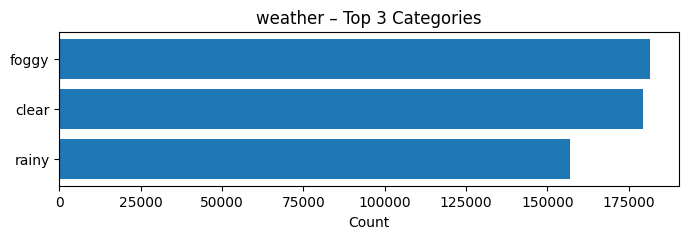

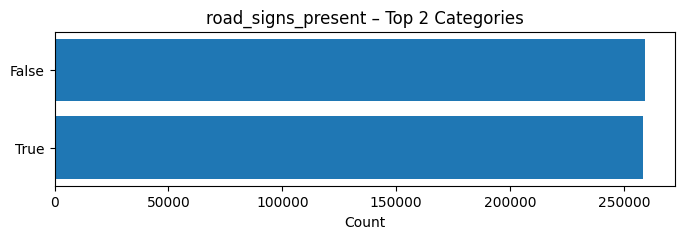

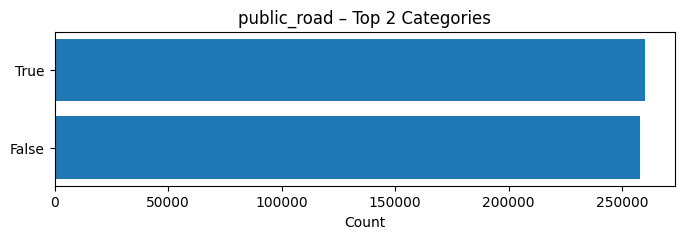

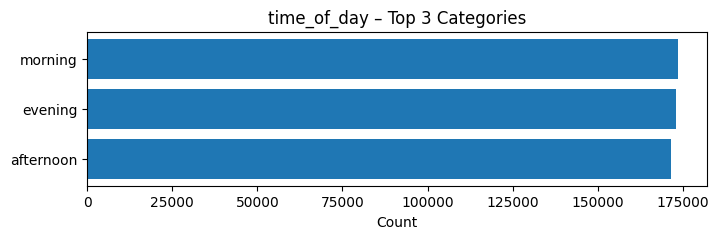

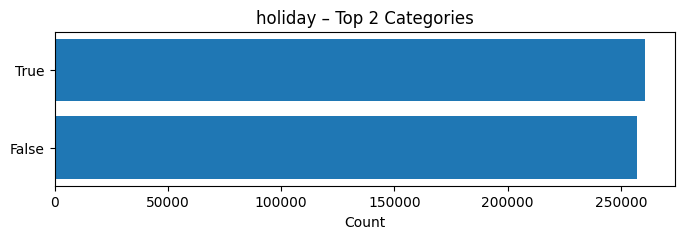

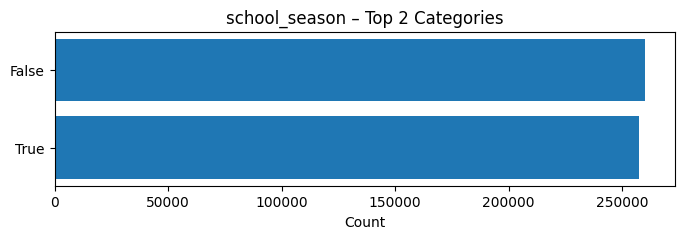

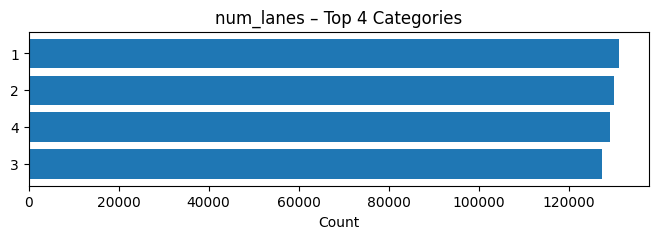

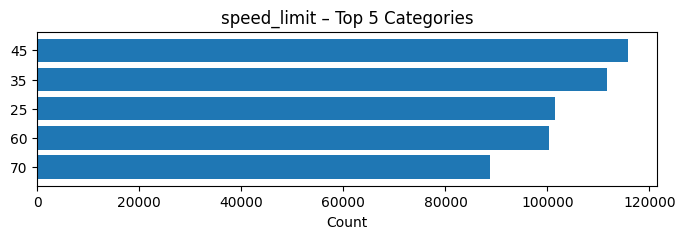

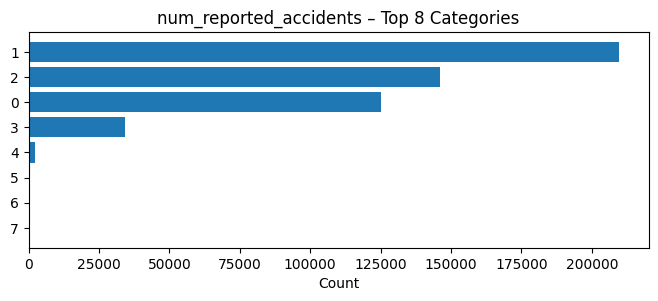

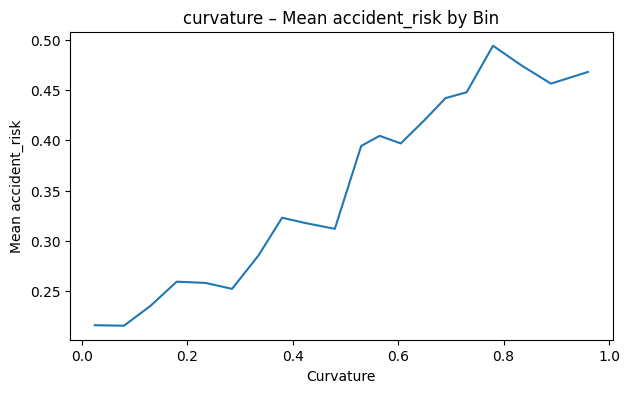

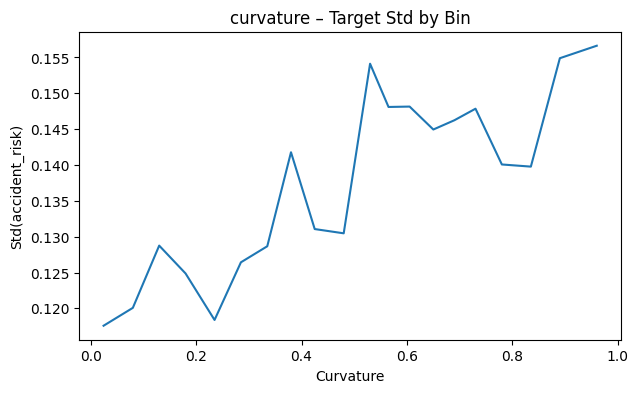

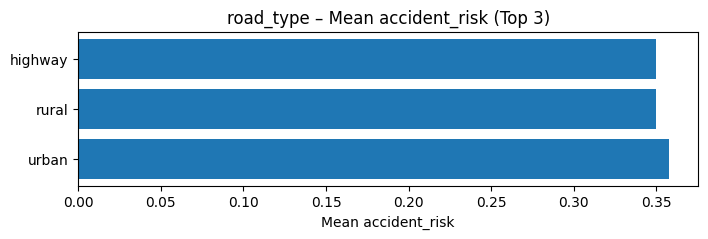

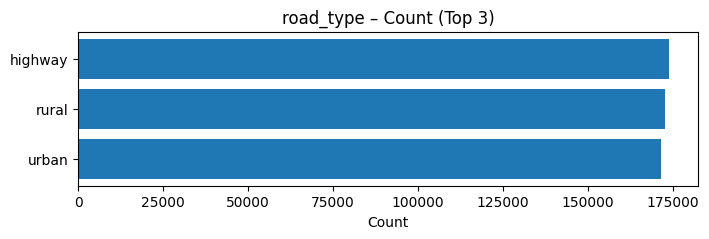

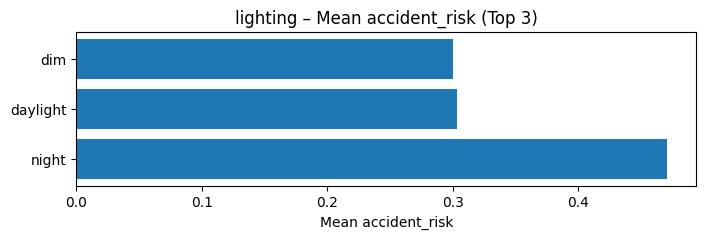

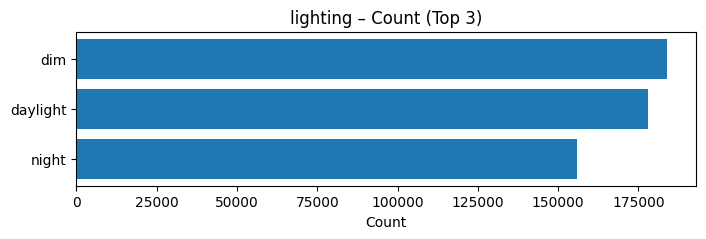

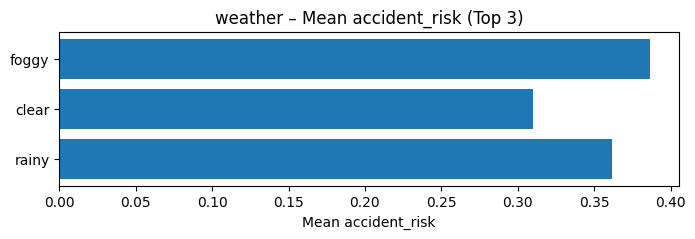

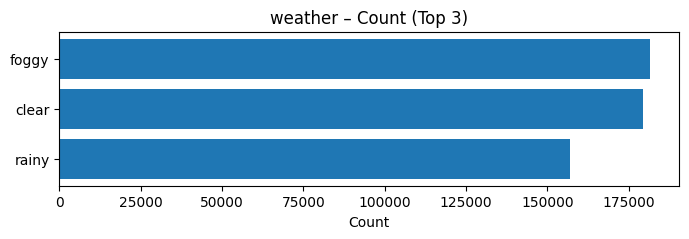

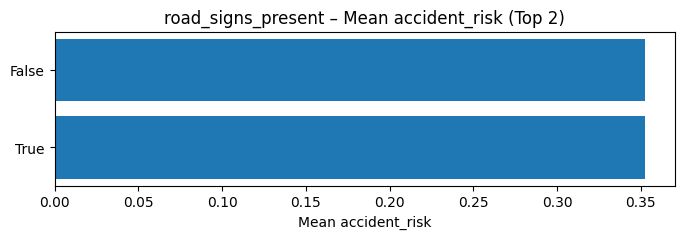

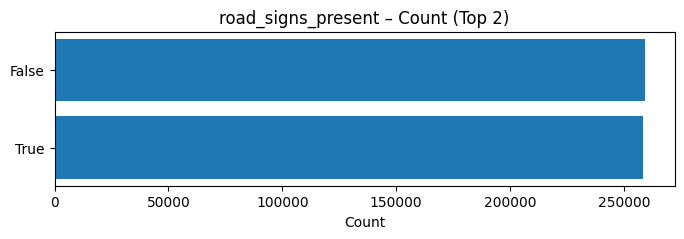

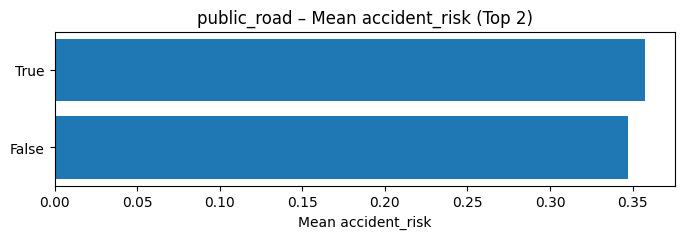

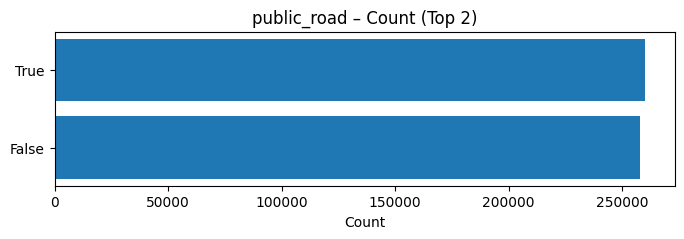

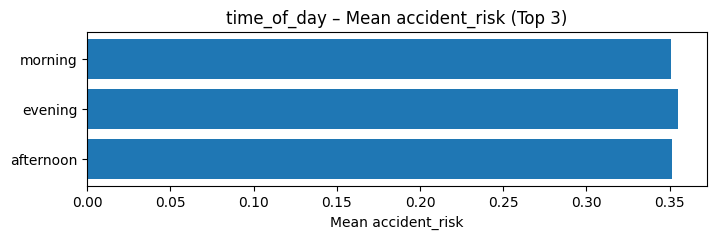

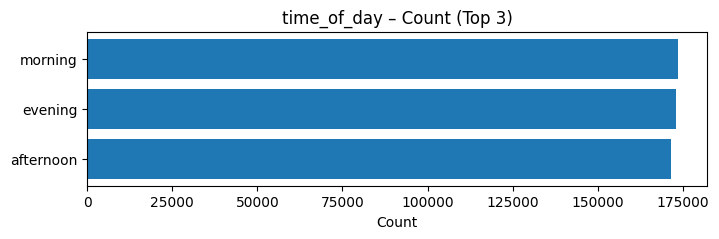

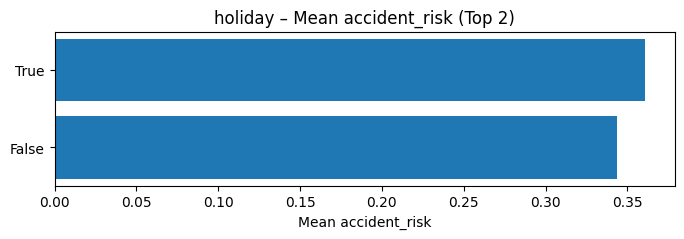

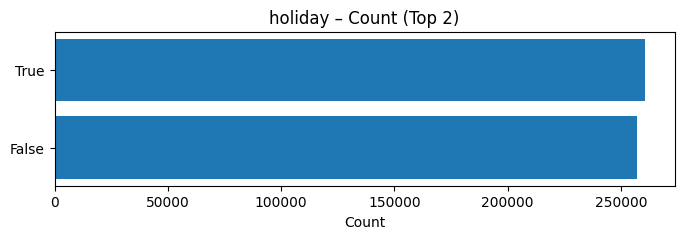

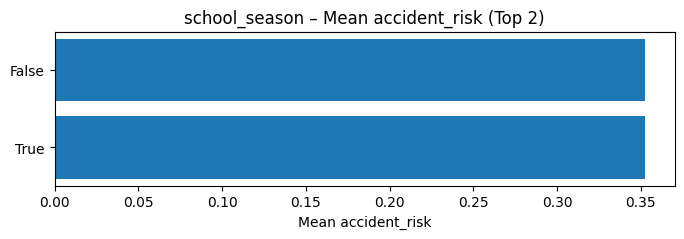

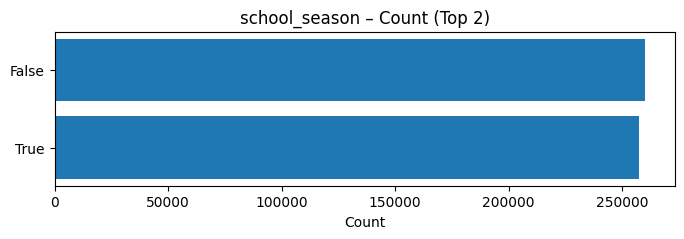

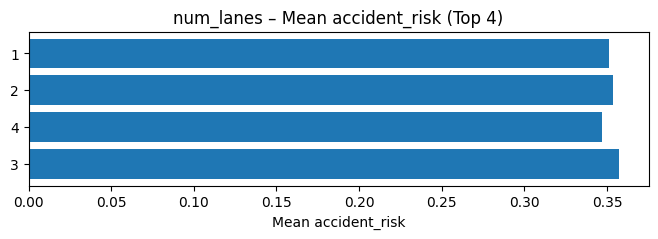

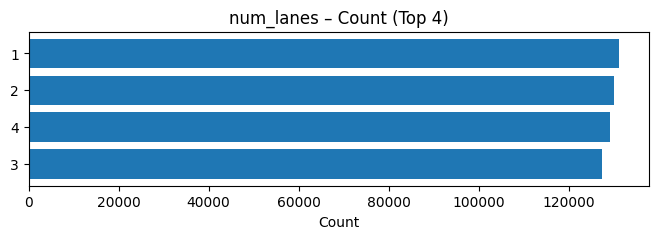

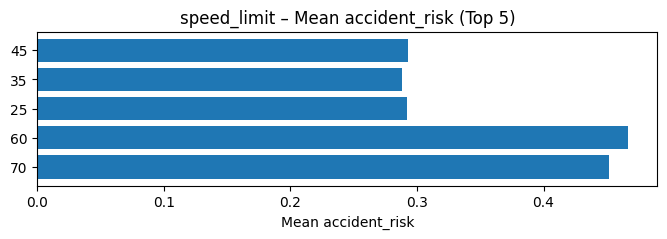

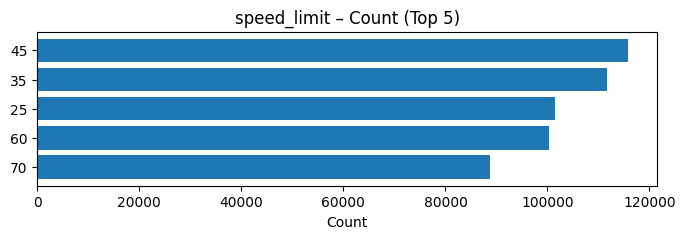

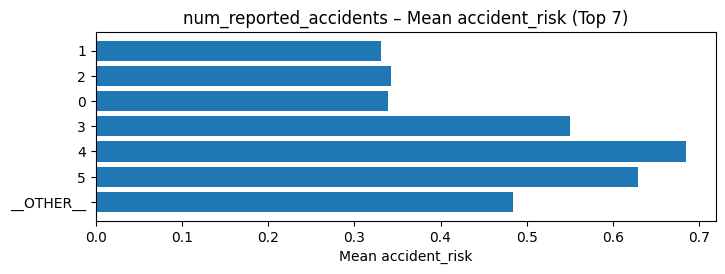

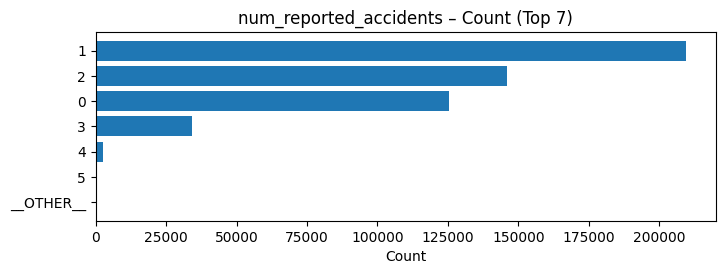

In [26]:
run_eda(training_df, target=TARGET, max_cat_card=30)

## Test Dataset EDA

Numeric: 1 | Categorical (≤30 uniq): 11
No missing values.


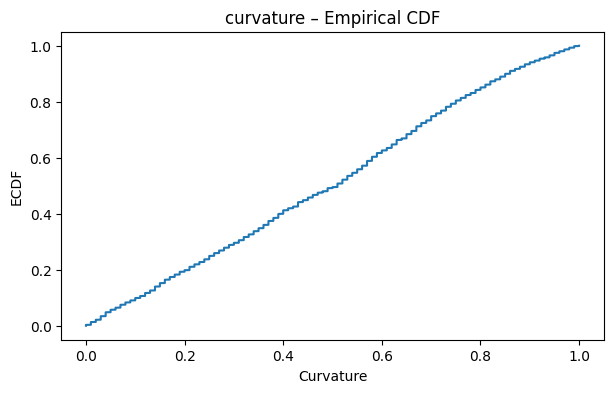

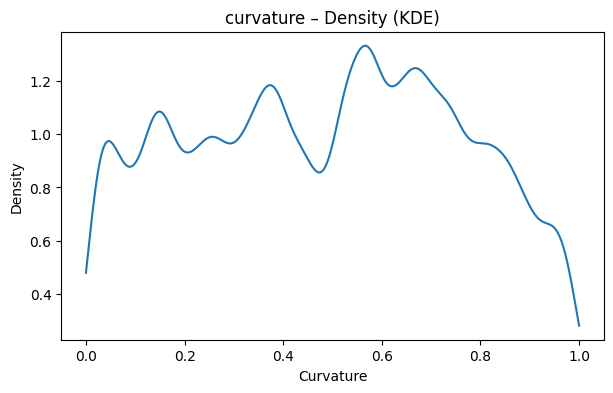

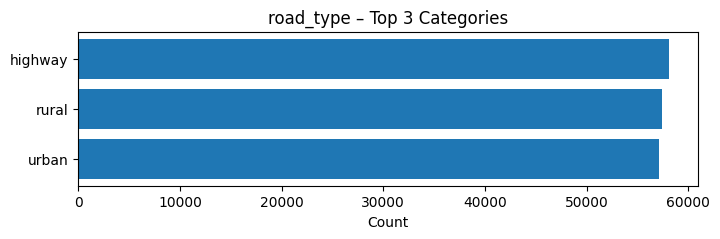

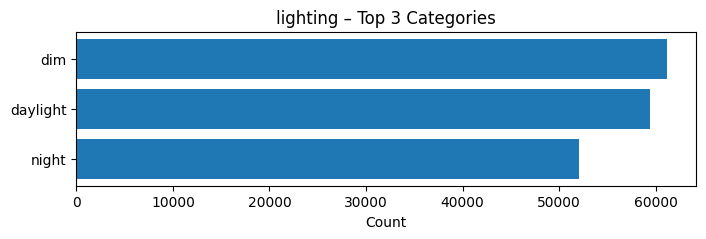

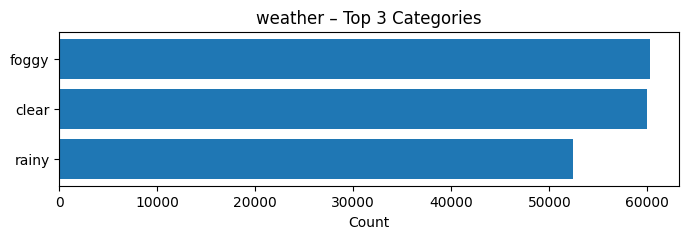

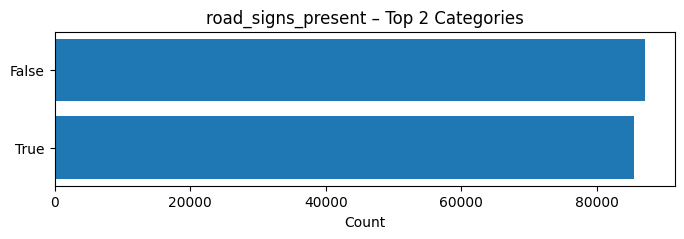

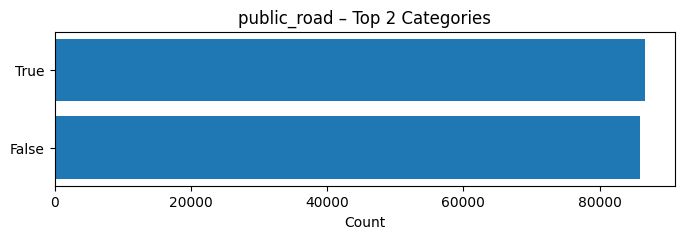

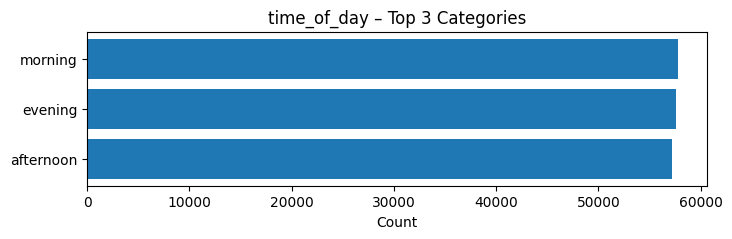

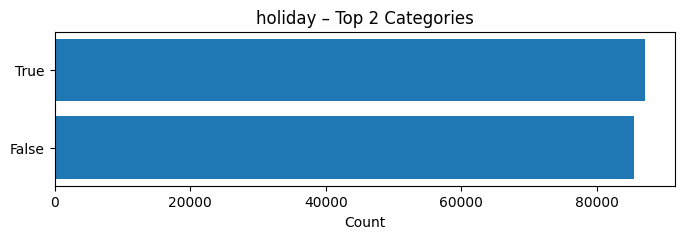

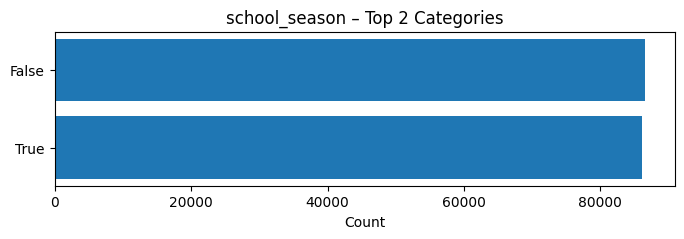

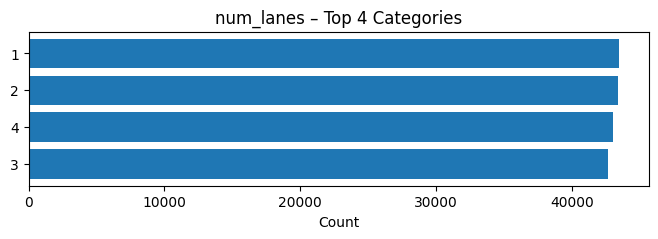

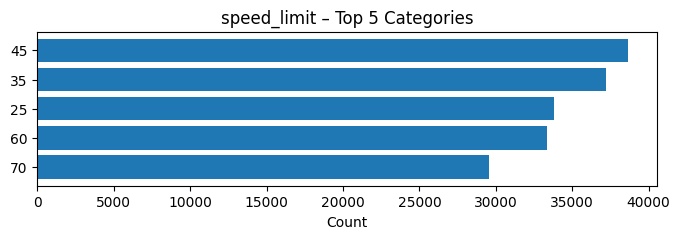

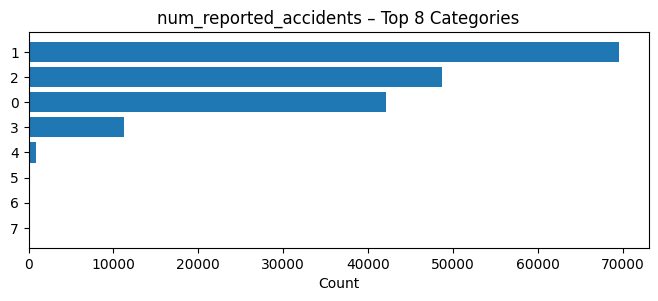

In [27]:
run_eda(test_df, target=TARGET, max_cat_card=30)

## Original Dataset EDA

In [28]:
ORIGINAL_DIR = Path("/kaggle/input/simulated-roads-accident-data") if running_in_kaggle() else Path("original_data")

original_df = pd.read_csv(ORIGINAL_DIR / 'synthetic_road_accidents_100k.csv')
original_df

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,rural,2,0.290,70,night,rainy,False,True,evening,False,False,1,0.640
1,highway,1,0.340,25,dim,clear,False,False,morning,False,False,3,0.270
2,rural,2,0.760,70,night,foggy,True,False,evening,True,True,1,0.760
3,rural,3,0.370,70,night,foggy,True,False,morning,False,True,0,0.600
4,highway,3,0.390,45,dim,rainy,False,True,morning,False,False,0,0.170
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,rural,2,0.610,60,dim,foggy,False,True,evening,False,False,1,0.540
99996,rural,2,0.520,35,dim,foggy,True,True,afternoon,False,False,1,0.180
99997,rural,2,0.080,70,daylight,clear,False,False,evening,True,False,1,0.200
99998,rural,1,0.830,70,dim,foggy,False,True,morning,False,True,0,0.580


Numeric: 1 | Categorical (≤30 uniq): 11
No missing values.


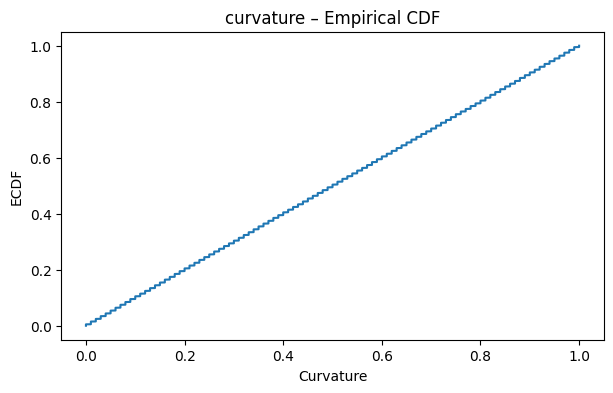

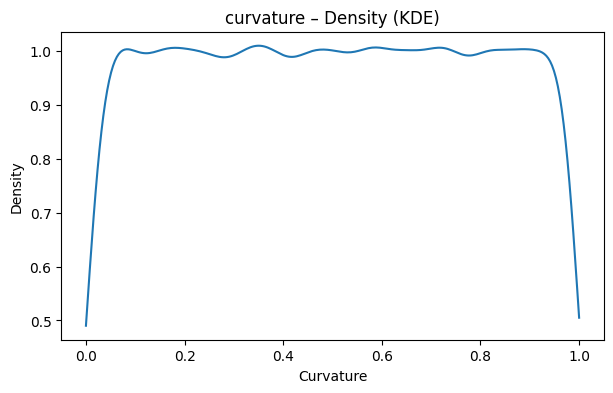

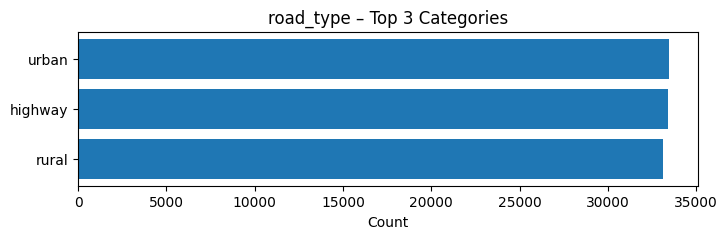

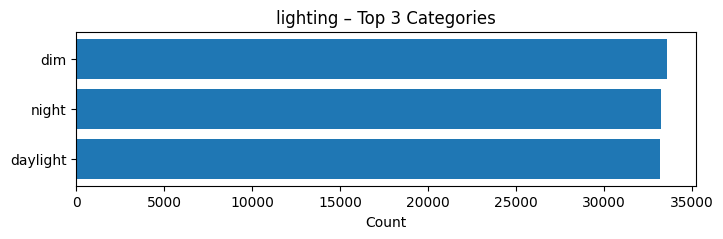

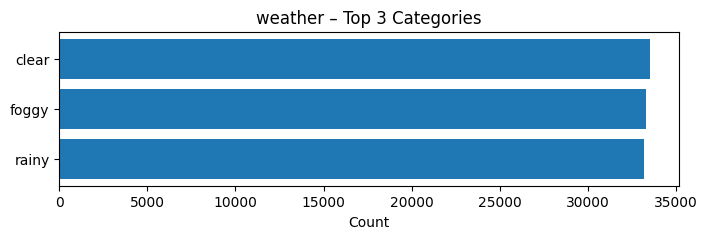

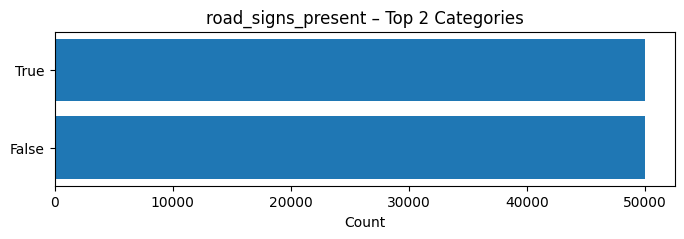

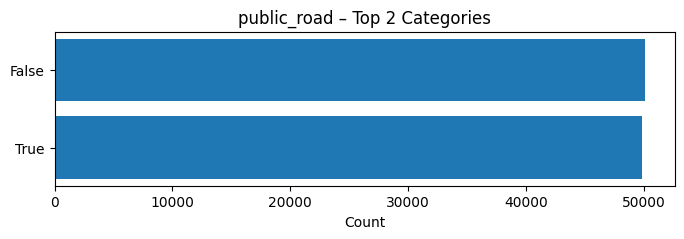

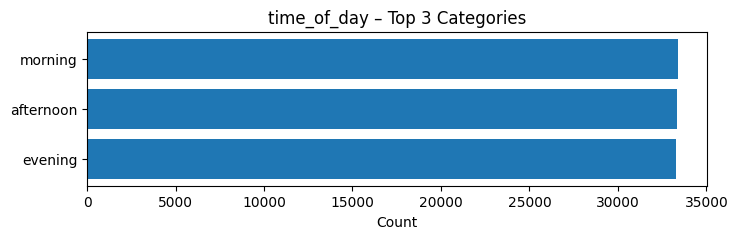

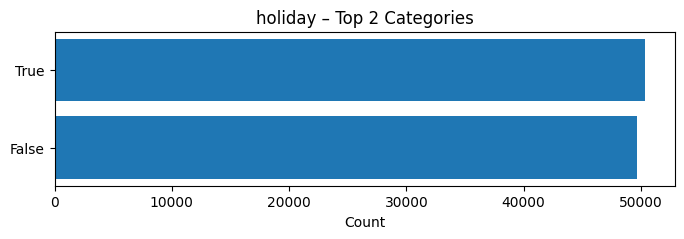

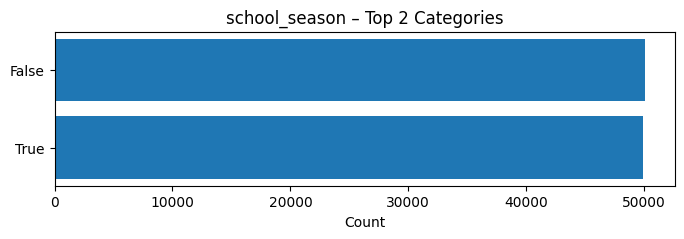

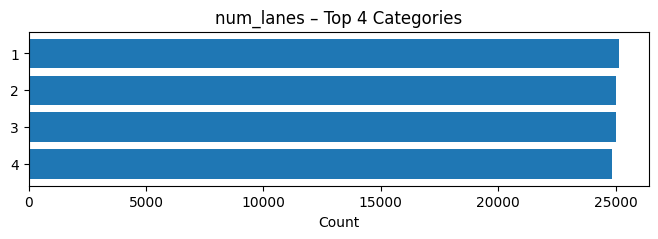

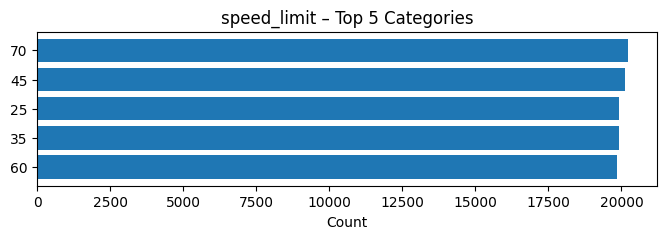

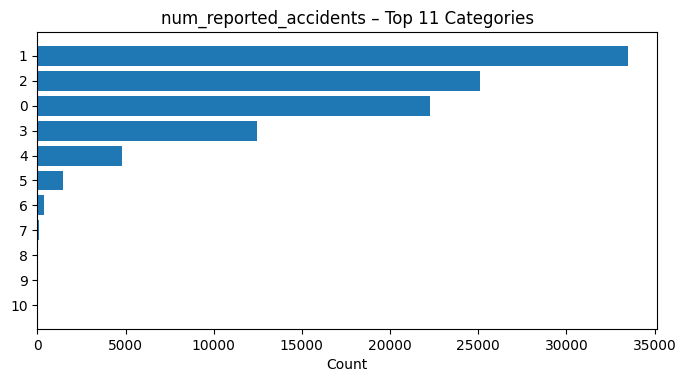

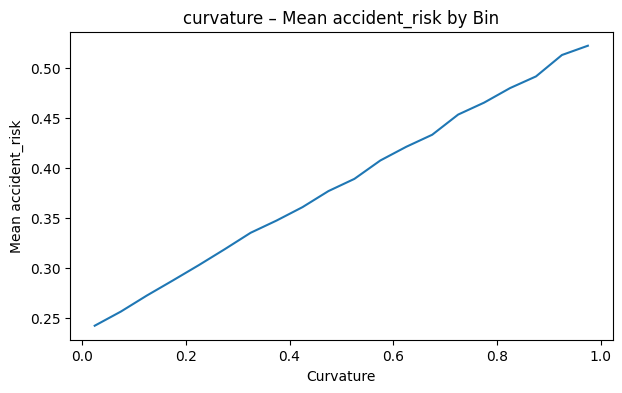

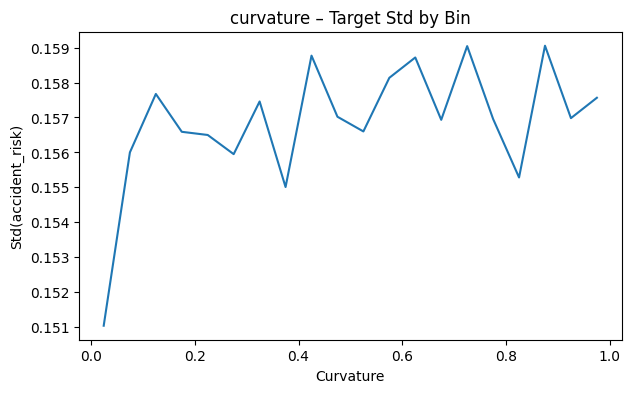

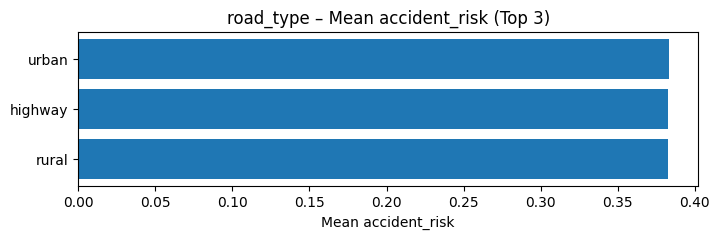

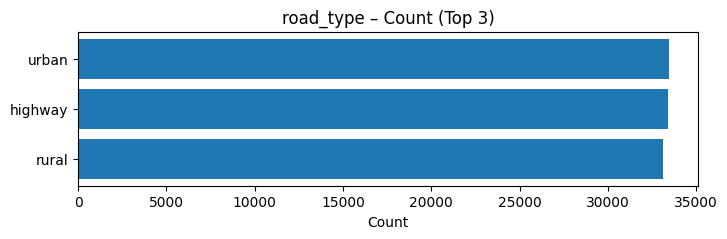

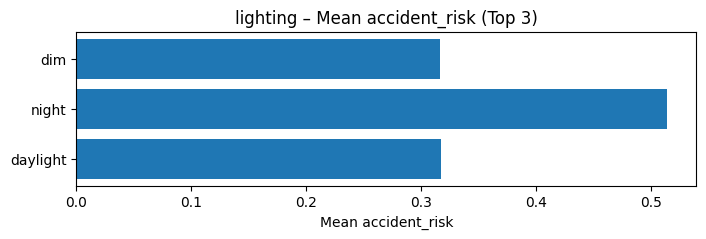

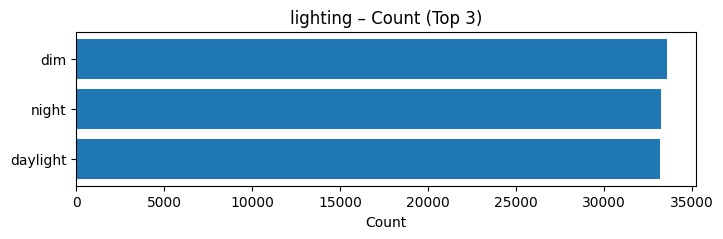

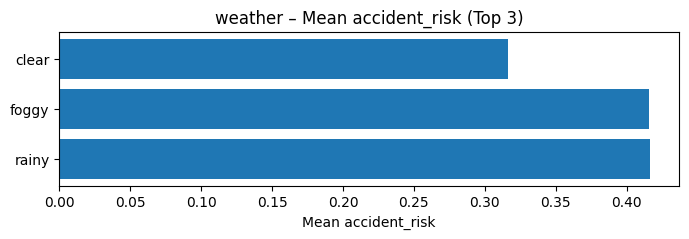

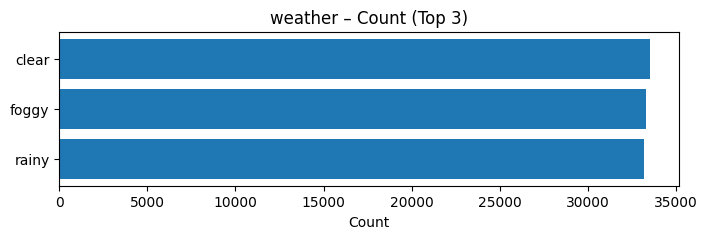

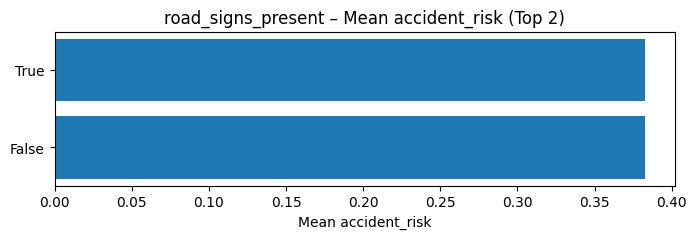

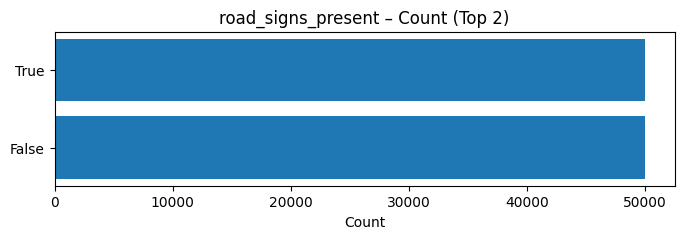

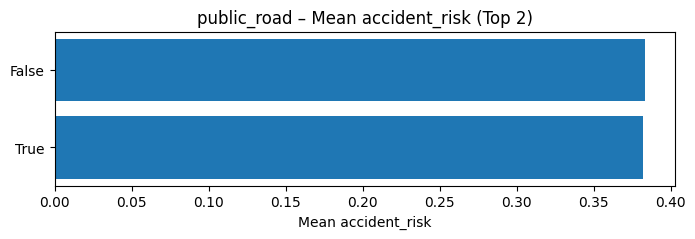

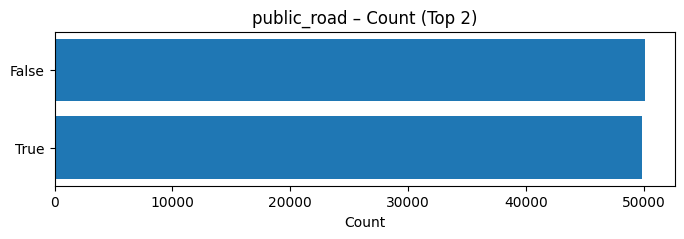

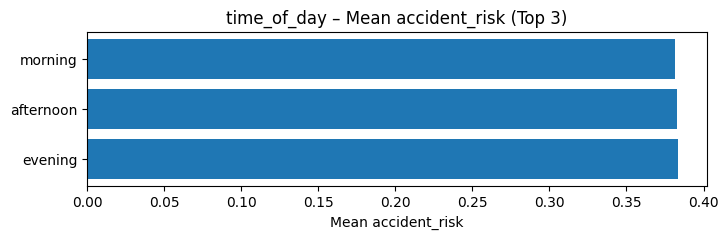

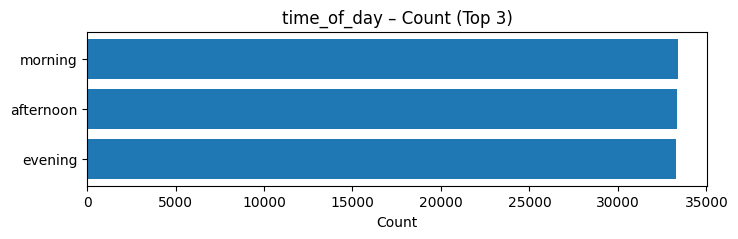

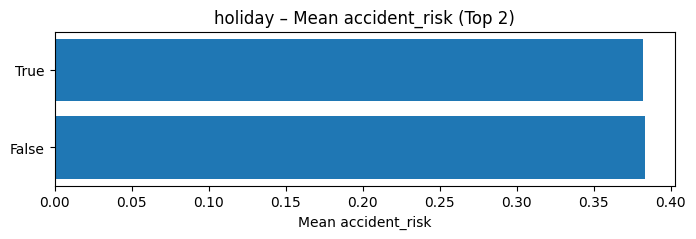

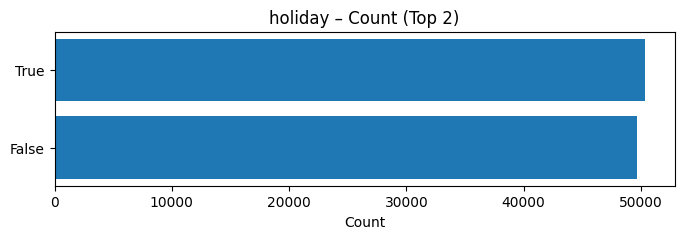

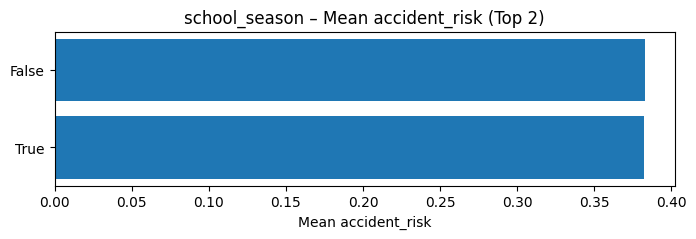

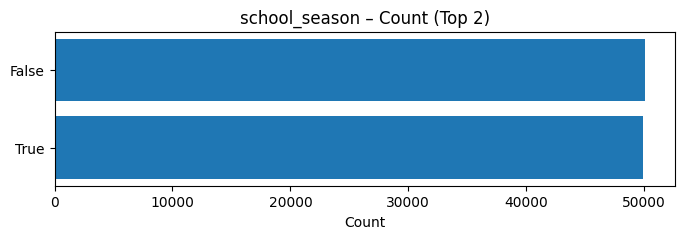

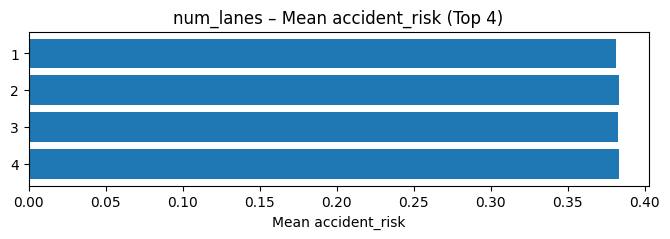

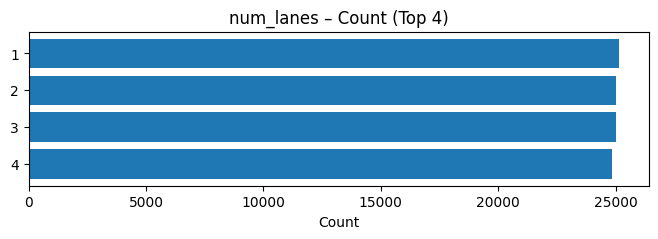

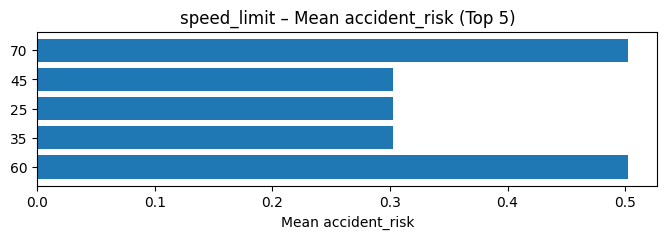

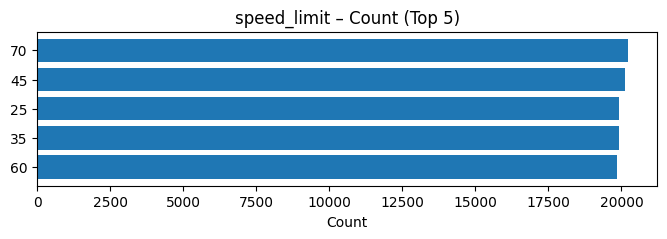

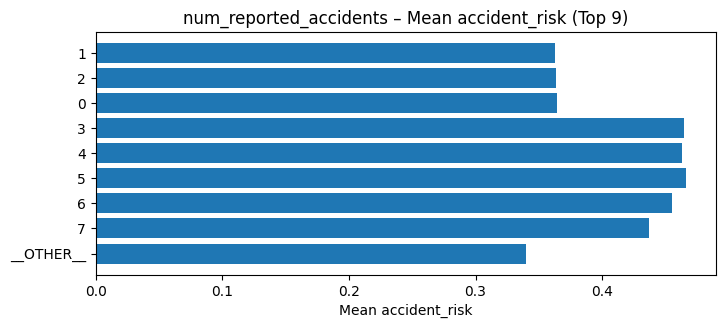

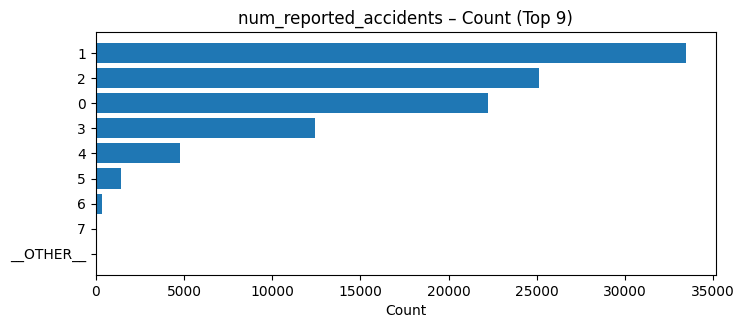

In [29]:
run_eda(original_df, target=TARGET, max_cat_card=30)

The **BeatsPerMinute** histogram shows a broad spread typical of mixed genres, with the bulk of tracks sitting in the common musical range (roughly moderato to allegro). You may notice mild clustering around tempo “equivalents” (e.g., ~60 and ~120 BPM) due to human perception and annotation habits—double/half-time interpretations often create secondary peaks. The tail behavior looks well-behaved (few extreme outliers), which is good news for RMSE.

**Modeling takeaway:** Because RMSE punishes large errors, watch for octave (×2/÷2) mistakes; a simple tempo-equivalence post-check (e.g., comparing predictions against ½×/2× variants) can reduce those.


### Feature distributions

## Dataset Comparison Report

**TODO**

## Feature Engineering

**TODO**

## Prepare Submission

In [30]:
# Build submission

# TODO